# Task 4: NN with PyTorch
# CENG501 - Spring 2021 - PA1

In this task, you will implement a fully-connected neural network (a.k.a. multi-layer perceptron) with PyTorch. In the previous tasks, we implemented everything from scratch (well, almost). Using PyTorch, we will see that loading widely used datasets, defining models and training them are very easy.


## 1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [ ]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time

# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### 1.1 Enable GPU

From "Edit -> Notebook Settings -> Hardware accelerator" select GPU. With the following we will specify to PyTorch that we want to use the GPU.

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset. 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.1 Visualize Samples

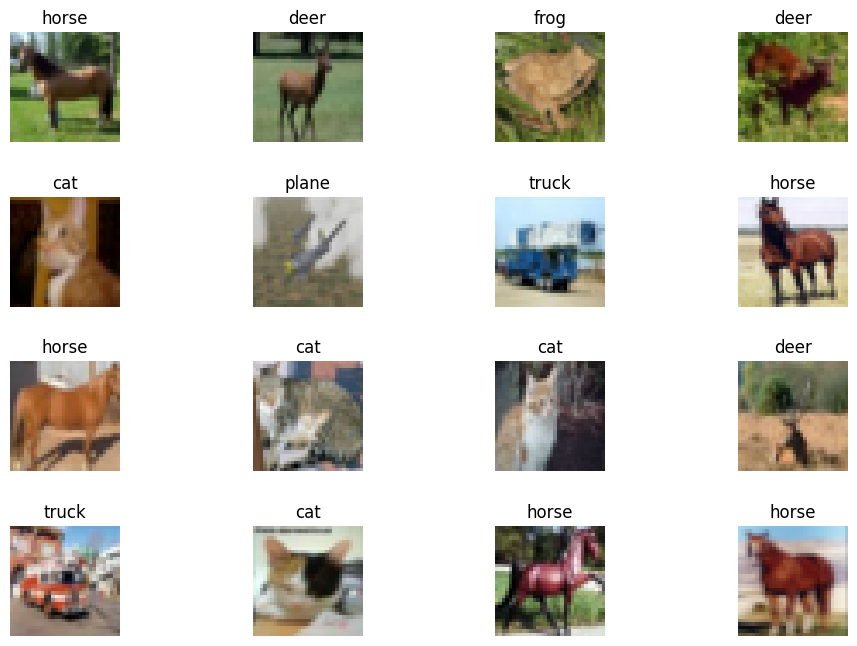

In [ ]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = dataiter.next()
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 4 Define and Train a Small Model

Now, all the pieces are ready and we can define a model.

### 4.1 Model Definition

Thanks to our modular definition, we can define models in a very simple manner as follows. Note that this is very similar to how you would define a model in PyTorch. For how to create a linear layer and add non-linearity, check out the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [ReLU](https://pytorch.org/docs/stable/nn.functional.html?highlight=relu#torch.nn.functional.relu) document pages of PyTorch. The linear layer weights should have bias.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TwoLayerNet(nn.Module):
    def __init__(self, D, H, C):
        super(TwoLayerNet, self).__init__()
        torch.manual_seed(501)        
        self.fc1 = None
        self.fc2 = None
        ###########################################################
        # @TODO: Create two linear layers                         #
        #  (1) One with size D x H and store in self.fc1          #
        #  (2) Second with size H x C and store in self.fc2       #
        ###########################################################
        self.fc1  =  nn.Linear(D,H)
        self.fc2  =  nn.Linear(H,C)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers. Be careful     #
      # about the shape of x. It needs to be reshaped to        #
      # (batchsize, 3072) first. Needs to return x. Apply relu  #
      # nonlinearity after the first layer.                     #
      ###########################################################
      x = x.reshape(x.shape[0],3072)
      x = self.fc1(x)
      x = nn.ReLU()(x)
      x = self.fc2(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 4.2 Define Loss Function and the Optimizer

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:
import torch.optim as optim

D = 3072 # dimensionality
C = 10 # num of classes
H = 200 # number of hidden neurons

model = TwoLayerNet(D, H, C)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-1)

### 4.3 Train the Model

We will train our the cuda device for training our model. Since our model is too small, we may not see any benefit of the GPU. In fact, the transfer between the CPU and the GPU might exceed the benefit we get from the speedup we obtain from the GPU.

In [ ]:

def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)
      

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

In [ ]:
model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 1.9125144720077514
Epoch 1 / 10: avg. loss of last 5 iterations 1.8504337549209595
Epoch 2 / 10: avg. loss of last 5 iterations 1.8479515314102173
Epoch 3 / 10: avg. loss of last 5 iterations 1.8053855895996094
Epoch 4 / 10: avg. loss of last 5 iterations 1.8066360712051392
Epoch 5 / 10: avg. loss of last 5 iterations 1.8195181369781495
Epoch 6 / 10: avg. loss of last 5 iterations 1.795068049430847
Epoch 7 / 10: avg. loss of last 5 iterations 1.824082350730896
Epoch 8 / 10: avg. loss of last 5 iterations 1.8261784076690675
Epoch 9 / 10: avg. loss of last 5 iterations 1.833475947380066


### 4.4 The Loss Curve

Let us visualize the loss curve.

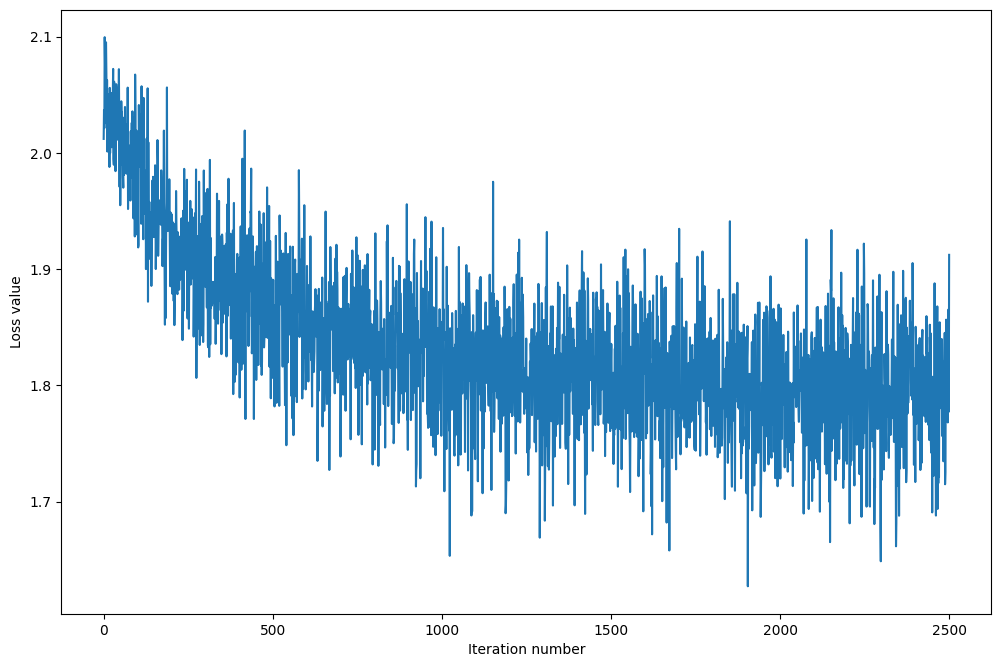

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 4.5 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 38\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 38 %


## 6 Try a Larger Model



### 6.1 Model Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ThreeLayerNet(nn.Module):
    def __init__(self, D, H1, H2, C):
        super(ThreeLayerNet, self).__init__()
        torch.manual_seed(501)        
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        ###########################################################
        # @TODO: Create three linear layers                       #
        #  (1) One with size D x H1 and store in self.fc1         #
        #  (2) Second with size H1 x H2 and store in self.fc2     #
        #  (3) Third with size H2 x HC and store in self.fc3      #
        ###########################################################
        self.fc1  =  nn.Linear(D,H1)
        self.fc2  =  nn.Linear(H1,H2)
        self.fc3  =  nn.Linear(H2,C)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers. Be careful     #
      # about the shape of x. It needs to be reshaped to        #
      # (batchsize, 3072) first. Needs to return x. Apply relu  #
      # nonlinearity after the first and second layers.         #
      ###########################################################
      x = x.reshape(x.shape[0],3072)
      x = self.fc1(x)
      x = nn.ReLU()(x)
      x = self.fc2(x)
      x = nn.ReLU()(x)
      x = self.fc3(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 6.2 Define the Loss Function and the Optimizer

In [ ]:
import torch.optim as optim

D = 3072 # dimensionality
C = 10 # num of classes
H1 = 1000 # number of hidden neurons
H2 = 100 # number of hidden neurons

model = ThreeLayerNet(D, H1, H2, C)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-2, weight_decay=1e-2)

### 6.3 Train the Model

In [ ]:
model = model.to(device)
epochs = 10

loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 1.7509853839874268
Epoch 1 / 10: avg. loss of last 5 iterations 1.6362876653671266
Epoch 2 / 10: avg. loss of last 5 iterations 1.5812842130661011
Epoch 3 / 10: avg. loss of last 5 iterations 1.5220166444778442
Epoch 4 / 10: avg. loss of last 5 iterations 1.4547698974609375
Epoch 5 / 10: avg. loss of last 5 iterations 1.4155205488204956
Epoch 6 / 10: avg. loss of last 5 iterations 1.3821622848510742
Epoch 7 / 10: avg. loss of last 5 iterations 1.3826517581939697
Epoch 8 / 10: avg. loss of last 5 iterations 1.4921271800994873
Epoch 9 / 10: avg. loss of last 5 iterations 1.2442209005355835


### 6.4 Loss Curve

Let us visualize the loss curve.

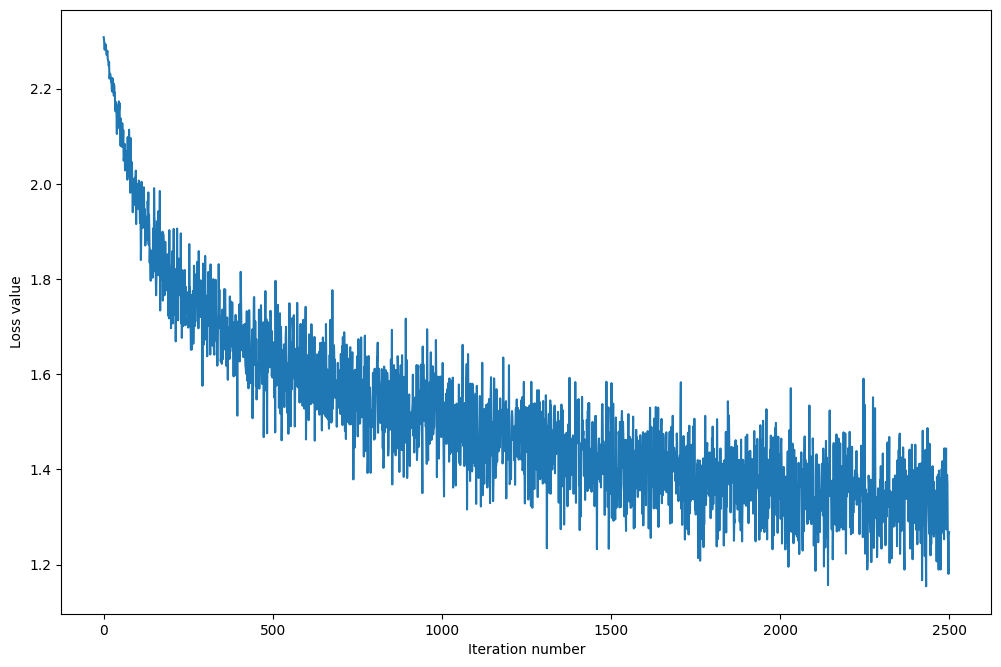

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 6.5 Quantitative Analysis

You should see around 52\% accuracy here. By finetuning the model, you should be able to obtain better results.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %
